In [1]:
from ISLP import confusion_table
from ISLP.models import (ModelSpec)
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     cross_validate)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm

### Q1

In [2]:
data = pd.read_csv("week4_data.csv")
data = data.iloc[:, 1:-1]
n_test_rows = math.floor(0.2 * len(data))
train_df, test_df = train_test_split(data, test_size = n_test_rows)

### Q2
- kNN, tune $k$
- Logistic Regression, tune threshold ($0.5\pm x$)
- Naive Bayes, tuning decision threshold
- LDA, tuning decision threshold

Visually, we can see that many predictors do not appear to follow a well behaved, i.e. normal, distribution. Many experience high degrees of skewness or potential fat-tail behaviour. As such, generative classifiers with assumptions of class priors will most likely underperform relative to discriminative classifiers.

Text(0.5, 1.01, 'Raw Distributions of Predictors in the Training Set (n=456)')

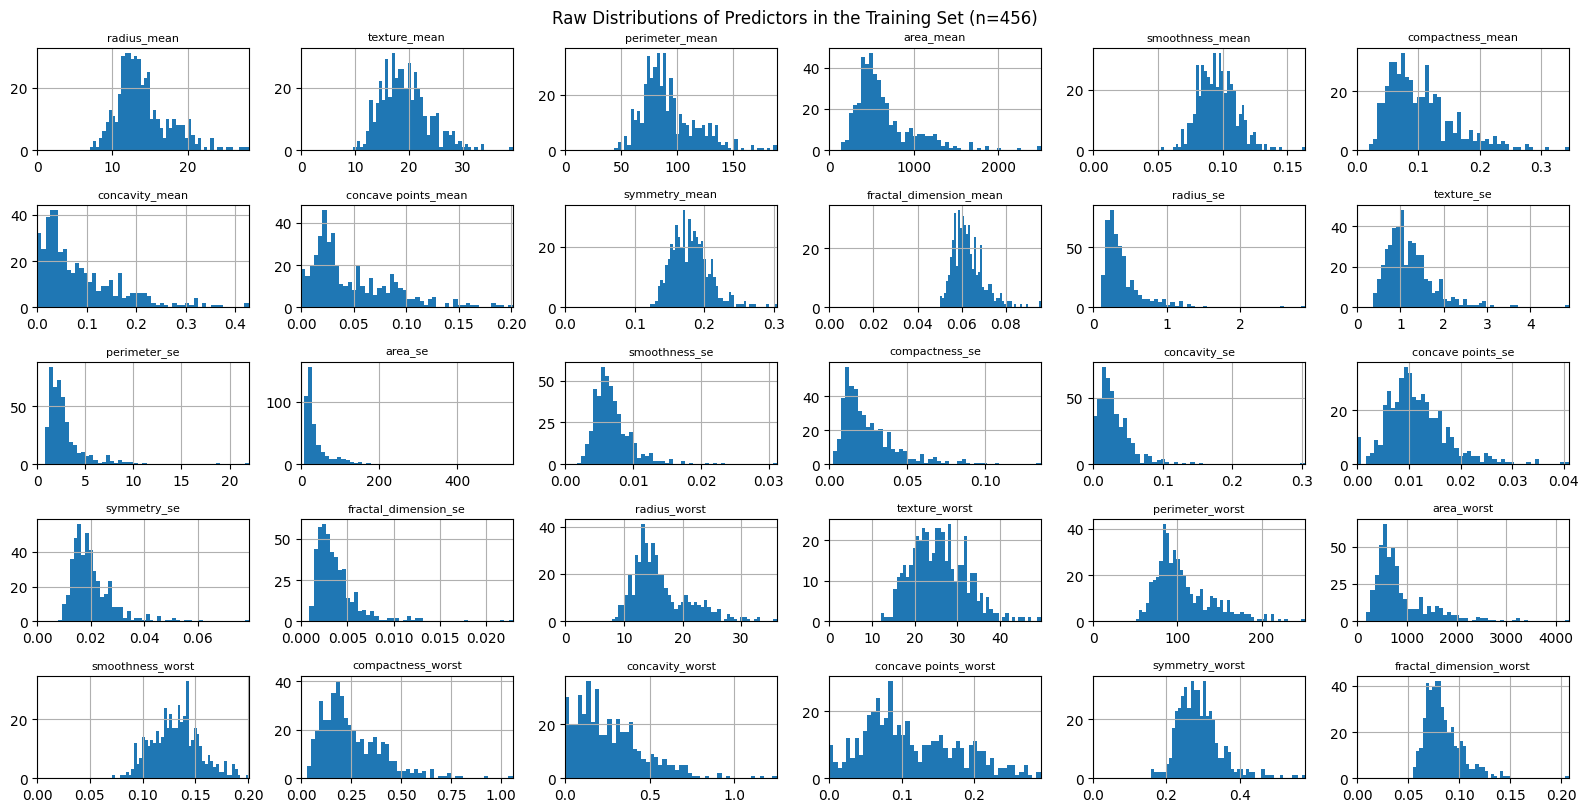

In [3]:
fig, axs = plt.subplots(nrows = 5, ncols = 6, figsize = (16, 8))
axs = list(itertools.chain(*axs))

for c, ax in zip(train_df.columns[1:,], axs):
    counts, bins = np.histogram(train_df[c], bins = 50)
    ax.hist(bins[:-1], bins, weights=counts)
    ax.grid()
    ax.set_title(c, fontsize=8)
    ax.set_xlim((0, train_df[c].max()))

fig.tight_layout()
fig.suptitle("Raw Distributions of Predictors in the Training Set (n=%.0f)" % len(train_df), y = 1.01)

### Q3
#### $kNN$, tuning $k$

In [4]:
Y = np.array(train_df['diagnosis'])
Y = (Y == 'M').astype(float)
X = train_df.iloc[:, 1:]
normed_X = (X - np.min(X))/(np.max(X) - np.min(X))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  r

In [5]:
k_values = range(3, 20)
n_k = len(k_values)
knn_cv_error = np.zeros(n_k)
for i, d in enumerate(k_values):
    kf = KFold(10, random_state=123, shuffle=True)
    knn_model = KNeighborsClassifier(n_neighbors = d)
    model_cv = cross_validate(knn_model,
                              normed_X,
                              Y,
                              cv=kf)
    knn_cv_error[i] = np.mean(model_cv['test_score'])
knn_min_error_idx = np.where(knn_cv_error == knn_cv_error.max())[0][-1]
optimal_k = k_values[int(knn_cv_error[knn_min_error_idx])]

print("Optimal k for kNN: %.0f. Accuracy of %.4f" % (optimal_k, knn_cv_error.max()))

Optimal k for kNN: 3. Accuracy of 0.9692


#### Logistic regression, tuning classification threshold

Unfortunately, it appears that there are variables that suffer from separation as can be seen by the below plot where fitted probabilities are constantly under $0.5$ (i.e. `fractal_dimension_mean`) . Due to this, logistic regression will not be pursued further, as a non-regularized logistic regression cannot be fit/converge on this dataset.

In [6]:
diagnosis_binary = (train_df['diagnosis'] == 'M').astype(float)

Text(0.5, 1.01, 'Binary Distribution of Predictors in the Training Set (n=456)')

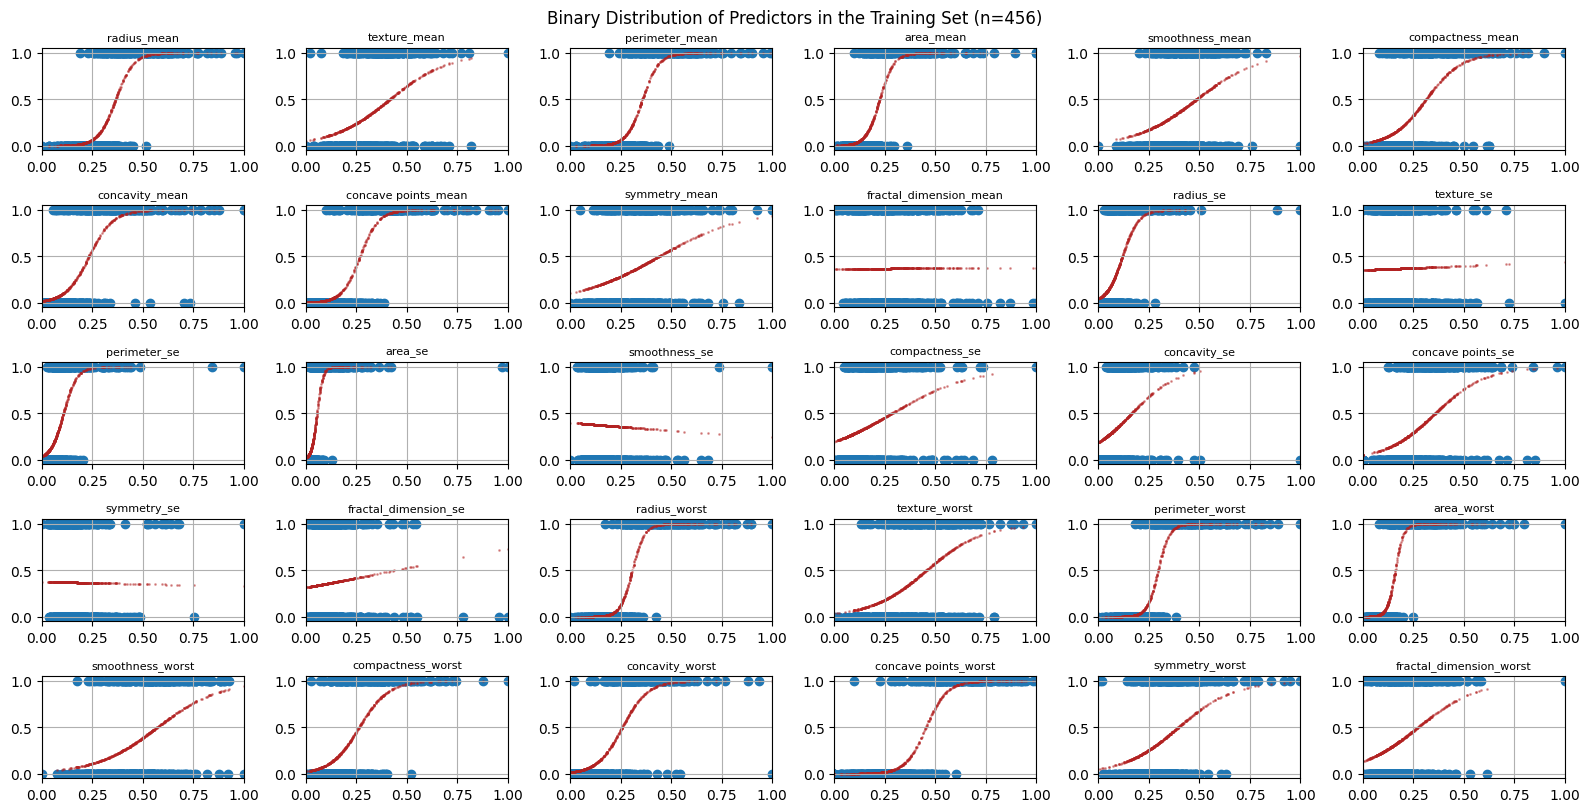

In [7]:
fig, axs = plt.subplots(nrows = 5, ncols = 6, figsize = (16, 8))
axs = list(itertools.chain(*axs))

for c, ax in zip(normed_X, axs):
    ax.scatter(x=normed_X[c],
               y=diagnosis_binary)
    c_design = ModelSpec([c])
    c_X_glm = c_design.fit_transform(pd.DataFrame(data={c: normed_X[c], 'diagnosis': diagnosis_binary}))
    model = sm.GLM(diagnosis_binary, c_X_glm, family = sm.families.Binomial()).fit()
    predicted_values = model.predict()
    ax.scatter(x=normed_X[c],
               y=predicted_values,
               color='firebrick',
               alpha=0.4,
               s=1)
    ax.grid()
    ax.set_title(c, fontsize=8)
    ax.set_xlim((0, normed_X[c].max()))

fig.tight_layout()
fig.suptitle("Binary Distribution of Predictors in the Training Set (n=%.0f)" % len(normed_X), y = 1.01)

#### Naive Bayes, tuning classification threshold

In [8]:
def classify_outcome(raw_probs,
                     threshold: float):
    """
    Check raw probabilities against a threshold to determine binary outcomes
    """
    pred_outcomes = np.zeros(len(raw_probs))
    for i, prob in enumerate(raw_probs):
        true_prob = prob[1]
        pred_outcomes[i] = true_prob >= threshold

    return pred_outcomes


def evaluate_outcome_truth(y_hat, y):
    """
    Evaluate element wise equality of two list likes
    """
    if len(y_hat) != len(y):
        raise ValueError("Uneven lists passed of length %.0f and %.0f" % (len(y_hat), len(y)))
    
    return y_hat == y


def calculate_accuracy(y_hat, y):
    """
    Calculate accuracy of y_hat versus y
    """
    outcome_truths = evaluate_outcome_truth(y_hat, y)

    return np.mean(outcome_truths)


evaluation_thresholds = np.arange(0.1, 0.9, 0.05)
nb_accuracies = np.zeros(len(evaluation_thresholds))

for i, thresh in enumerate(evaluation_thresholds):
    NB = GaussianNB()
    kf = KFold(10, random_state=123, shuffle=True)
    nb_model_cv = cross_validate(NB,
                                normed_X,
                                Y,
                                cv=kf,
                                return_estimator=True)
    estimators = nb_model_cv['estimator']
    test_indices = [test_i for _, test_i in kf.split(normed_X)]
    test_frames = [normed_X.iloc[x, :] for x in test_indices]
    raw_probs = [est.predict_proba(test_df) for est, test_df in zip(estimators, test_frames)]
    outcomes = [classify_outcome(x, thresh) for x in raw_probs]
    test_y = [Y[x] for x in test_indices]
    pred_accuracies = [calculate_accuracy(x, Y_slice) for x, Y_slice in zip(outcomes, test_y)]
    
    nb_accuracies[i] = np.mean(pred_accuracies)

nb_max_accuracy_idx = np.where(nb_accuracies == np.max(nb_accuracies))[0][0]
nb_max_accuracy = nb_accuracies[nb_max_accuracy_idx]
nb_optimal_threshold = evaluation_thresholds[nb_max_accuracy_idx]

print("Optimal probability threshold for NB: %.2f. Accuracy of %.4f" % (nb_optimal_threshold, nb_max_accuracy))

Optimal probability threshold for NB: 0.10. Accuracy of 0.9366


#### LDA, tuning for decision threshold

In [9]:
lda_accuracies = np.zeros(len(evaluation_thresholds))

for i, thresh in enumerate(evaluation_thresholds):
    lda = LinearDiscriminantAnalysis()
    kf = KFold(10, random_state=123, shuffle=True)
    lda_model_cv = cross_validate(lda,
                                  normed_X,
                                  Y,
                                  cv=kf,
                                  return_estimator=True)
    estimators = lda_model_cv['estimator']
    test_indices = [test_i for _, test_i in kf.split(normed_X)]
    test_frames = [normed_X.iloc[x, :] for x in test_indices]
    raw_probs = [est.predict_proba(test_df) for est, test_df in zip(estimators, test_frames)]
    outcomes = [classify_outcome(x, thresh) for x in raw_probs]
    test_y = [Y[x] for x in test_indices]
    pred_accuracies = [calculate_accuracy(x, Y_slice) for x, Y_slice in zip(outcomes, test_y)]
    
    lda_accuracies[i] = np.mean(pred_accuracies)

lda_max_accuracy_idx = np.where(lda_accuracies == np.max(lda_accuracies))[0][0]
lda_max_accuracy = lda_accuracies[lda_max_accuracy_idx]
lda_optimal_threshold = evaluation_thresholds[lda_max_accuracy_idx]

print("Optimal probability threshold for LDA: %.2f. Accuracy of %.4f" % (lda_optimal_threshold, lda_max_accuracy))

Optimal probability threshold for LDA: 0.25. Accuracy of 0.9781


### Q4

The best model above is kNN with $k=3$, which is expected as a non-generative classifier against non-Gaussian data.

In [10]:
test_Y = np.array(test_df['diagnosis'])
test_Y = (test_Y == 'M').astype(float)
test_X = test_df.iloc[:, 1:]
normed_test_X = (test_X - np.min(test_X))/(np.max(test_X) - np.min(test_X))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  r

In [11]:
best_knn = KNeighborsClassifier(n_neighbors = 3)
best_knn_model = best_knn.fit(normed_X, Y)
final_pred = best_knn.predict(normed_test_X)
conf_table = confusion_table(final_pred, test_Y)
final_accuracy = np.mean(final_pred==test_Y)
final_sensitivity = conf_table.iloc[-1, -1]/conf_table.iloc[:, -1].sum()
final_specificity = conf_table.iloc[0, 0]/conf_table.iloc[:, 0].sum()

print("Final accuracy: %.2f\nFinal sensitivity: %.2f\nFinal specificity: %.2f" % (final_accuracy,
                                                                                  final_sensitivity,
                                                                                  final_specificity))

Final accuracy: 0.94
Final sensitivity: 0.98
Final specificity: 0.91
